In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf

IMG_SIZE = [512, 512]

def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    return img

def load_msk(path):
    msk = np.load(path)
    msk = cv2.resize(msk, dsize=IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('on')
    
def load_imgs(img_paths):
    imgs = np.zeros((*IMG_SIZE, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path)
        imgs[..., i]+=img
    return imgs

In [2]:
df = pd.read_csv('/home/yiw/gi/train_step0.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np/').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head(199)

<ipython-input-2-d990053b069b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['mask_path'] = df.mask_path.str.replace('/png/','/np/').str.replace('.png','.npy')


,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
...,...,...,...,...,...,...,...,...,...,...,...
194,case123_day22_slice_0051,123,22,51,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
195,case123_day22_slice_0052,123,22,52,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
196,case123_day22_slice_0053,123,22,53,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
197,case123_day22_slice_0054,123,22,54,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True


In [3]:
channels=5
stride=1
for i in range(channels):
    # 0, -1, -2, -3, -4
    # 2, 1, 0, -1 , -2
    df[f'image_path_{i:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride+2).fillna(method="bfill").fillna(method="ffill")
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
df.image_paths.tolist()[0]

['/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png']

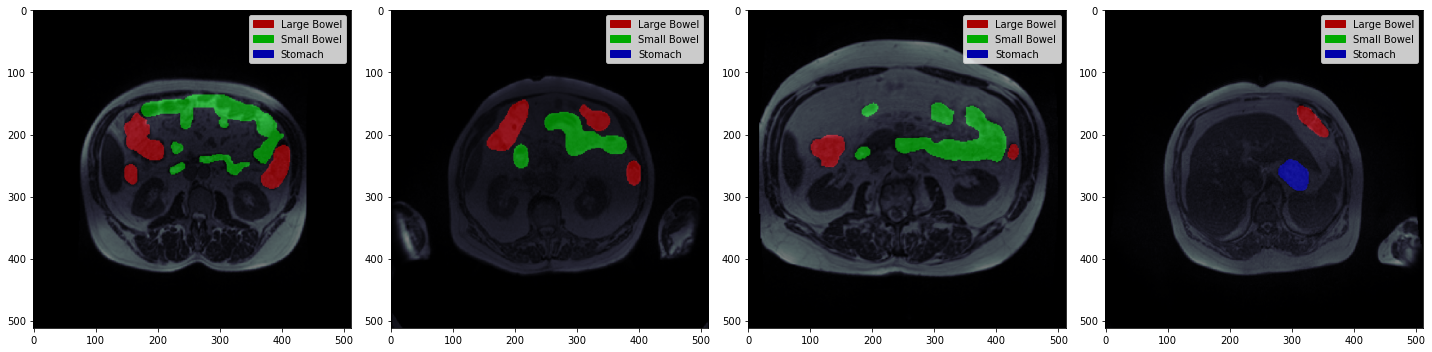

In [4]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[df['empty']==0].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = df[df['id']==id_]
    img = load_img(idf.image_path.iloc[0])
    mask = load_msk(idf.mask_path.iloc[0])
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

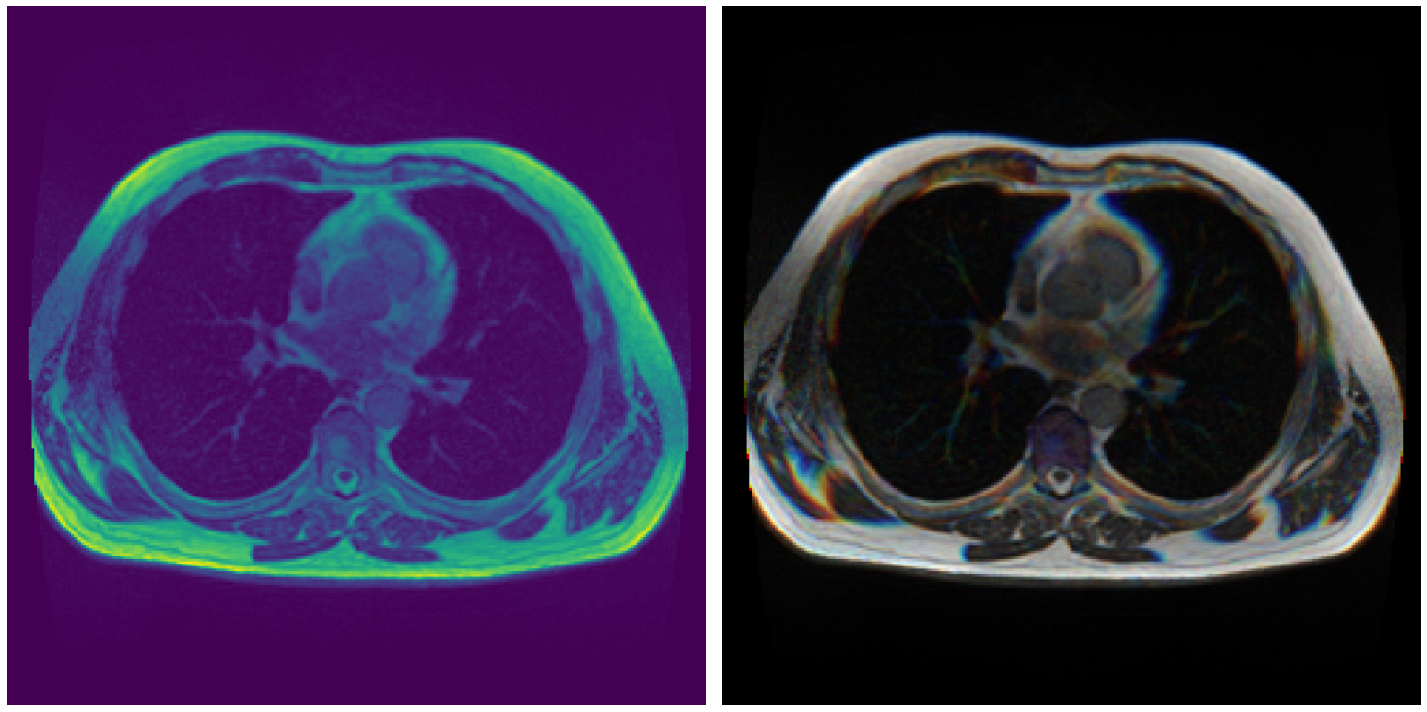

In [5]:
idx = 40

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(df.image_path[idx]).astype('float32')
img/=img.max()
plt.imshow(img)
plt.axis('off')

# TypeError: Invalid shape (512, 512, 5) for image data
plt.subplot(1, 2, 2)
imgs = load_imgs(df.image_paths[idx]).astype('float32')
imgs/=imgs.max(axis=(0,1))
plt.imshow(imgs[..., 0:3])
plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
IMAGE_DIR = '/tmp/images'
MASK_DIR = '/tmp/masks'
!mkdir -p $IMAGE_DIR && mkdir -p $MASK_DIR

def save_mask(id_):
    row = df[df['id']==id_].squeeze()

    img_paths = row.image_paths
    imgs = load_imgs(img_paths)
    np.save(f'{IMAGE_DIR}/{id_}.npy', imgs)
    
    msk_path = row.mask_path
    msk = load_msk(msk_path)
    np.save(f'{MASK_DIR}/{id_}.npy', msk)
    
    return

ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_)\
                                             for id_ in tqdm(ids, total=len(ids)))
# 把 images 和 masks 文件夹拷贝到 ~/gi/input/

  0%|          | 0/38496 [00:00<?, ?it/s]

In [17]:
plt.figure(figsize=(21, 7))

imgs = np.load(f'{IMAGE_DIR}/case123_day0_slice_0080.npy').astype('float32')
imgs/=imgs.max(axis=(0,1))

plt.subplot(1, 3, 1)
plt.imshow(imgs[..., 1:4])

msk = np.load(f'{MASK_DIR}/case123_day0_slice_0080.npy').astype('float32')
msk/=255.0

plt.subplot(1, 3, 2)
plt.imshow(msk)


plt.subplot(1, 3, 3)
plt.imshow(imgs[..., 0:3])
plt.imshow(msk, alpha=0.5)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/images/case123_day0_slice_0080.npy'

<Figure size 1512x504 with 0 Axes>

In [8]:
df.to_csv('train_step1.csv', index=False)
df.head(199)

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty,image_path_00,image_path_01,image_path_02,image_path_03,image_path_04,image_paths
0,case123_day20_slice_0001,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,[/home/yiw/gi/input/train/case123/case123_day2...
1,case123_day20_slice_0002,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,[/home/yiw/gi/input/train/case123/case123_day2...
2,case123_day20_slice_0003,123,20,3,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,[/home/yiw/gi/input/train/case123/case123_day2...
3,case123_day20_slice_0004,123,20,4,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,[/home/yiw/gi/input/train/case123/case123_day2...
4,case123_day20_slice_0005,123,20,5,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,[/home/yiw/gi/input/train/case123/case123_day2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,case123_day22_slice_0051,123,22,51,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,[/home/yiw/gi/input/train/case123/case123_day2...
195,case123_day22_slice_0052,123,22,52,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,[/home/yiw/gi/input/train/case123/case123_day2...
196,case123_day22_slice_0053,123,22,53,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,/home/yiw/gi/input/train/case123/case123_day22...,[/home/yiw/gi/input/train/case123/case123_day2...
197,case123_day22_slice_0054,123,22,54,/home/yiw/gi/input/train/case123/case1

In [9]:
import pandas as pd

df = pd.read_csv("/home/yiw/gi/train_step1.csv")
df

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty,image_path_00,image_path_01,image_path_02,image_path_03,image_path_04,image_paths
0,case123_day20_slice_0001,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"['', '', '']",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,['/home/yiw/gi/input/train/case123/case123_day...
1,case123_day20_slice_0002,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"['', '', '']",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,['/home/yiw/gi/input/train/case123/case123_day...
2,case123_day20_slice_0003,123,20,3,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"['', '', '']",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,['/home/yiw/gi/input/train/case123/case123_day...
3,case123_day20_slice_0004,123,20,4,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"['', '', '']",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,['/home/yiw/gi/input/train/case123/case123_day...
4,case123_day20_slice_0005,123,20,5,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"['', '', '']",0,True,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,/home/yiw/gi/input/train/case123/case123_day20...,['/home/yiw/gi/input/train/case123/case123_day...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,30,0,140,/home/yiw/gi/input/train/case30/case30_day0/sc...,266,266,/home/yiw/gi/input/np/train/case30/case30_day0...,"['', '', '']",0,True,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,['/home/yiw/gi/input/train/case30/case30_day0/...
38492,case30_day0_slice_0141,30,0,141,/home/yiw/gi/input/train/case30/case30_day0/sc...,266,266,/home/yiw/gi/input/np/train/case30/case30_day0...,"['', '', '']",0,True,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,['/home/yiw/gi/input/train/case30/case30_day0/...
38493,case30_day0_slice_0142,30,0,142,/home/yiw/gi/input/train/case30/case30_day0/sc...,266,266,/home/yiw/gi/input/np/train/case30/case30_day0...,"['', '', '']",0,True,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,/home/yiw/gi/input/train/case30/case30_day0/sc...,['/home/yiw/gi/input/train/case30/case30_day0/...
38494,case30_day0_slice_0143,30,

In [10]:
df.height.unique()

array([266, 310, 234, 276])

In [11]:

df.width.unique()

array([266, 360, 234, 276])

In [16]:
pd.options.display.max_seq_items = 2000
pd.set_option("max_colwidth", None)

df.image_paths.iloc[-1]

"['/home/yiw/gi/input/train/case30/case30_day0/scans/slice_0142_266_266_1.50_1.50.png', '/home/yiw/gi/input/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png', '/home/yiw/gi/input/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png', '/home/yiw/gi/input/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png', '/home/yiw/gi/input/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png']"

In [13]:
df.image_path

0        /home/yiw/gi/input/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
1        /home/yiw/gi/input/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png
2        /home/yiw/gi/input/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png
3        /home/yiw/gi/input/train/case123/case123_day20/scans/slice_0004_266_266_1.50_1.50.png
4        /home/yiw/gi/input/train/case123/case123_day20/scans/slice_0005_266_266_1.50_1.50.png
                                                 ...                                          
38491       /home/yiw/gi/input/train/case30/case30_day0/scans/slice_0140_266_266_1.50_1.50.png
38492       /home/yiw/gi/input/train/case30/case30_day0/scans/slice_0141_266_266_1.50_1.50.png
38493       /home/yiw/gi/input/train/case30/case30_day0/scans/slice_0142_266_266_1.50_1.50.png
38494       /home/yiw/gi/input/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png
38495       /home/yiw/gi/input/train/case30/case30

In [14]:
pd.set_option('display.max_rows', None)
df.mask_path[64:99]

64    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.npy
65    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0066_266_266_1.50_1.50.npy
66    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0067_266_266_1.50_1.50.npy
67    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0068_266_266_1.50_1.50.npy
68    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0069_266_266_1.50_1.50.npy
69    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0070_266_266_1.50_1.50.npy
70    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0071_266_266_1.50_1.50.npy
71    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0072_266_266_1.50_1.50.npy
72    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0073_266_266_1.50_1.50.npy
73    /home/yiw/gi/input/np/train/case123/case123_day20/scans/slice_0074_266_266_1.50_1.50.npy
74    /home/yiw/gi/input/np/train/case123/case123_